In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

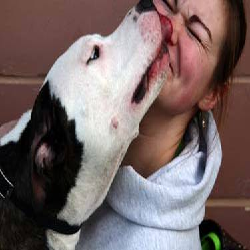

In [3]:
path = 'C:/Users/SOOQ ELASER/Desktop/cat_dog_dataset/training_set/dogs/dog.43.jpg'
img = load_img(path, target_size=(250,250))
img

In [41]:
#buliding image generator for training given two classes
train_gen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.3,
                                   zoom_range = 0.3,
                                   horizontal_flip = True)
train_ds = train_gen.flow_from_directory(directory = 'C:/Users/SOOQ ELASER/Desktop/cat_dog_dataset/training_set',
                                                 target_size = (150, 150),
                                                 batch_size = 4,
                                                 class_mode = 'binary')

Found 8000 images belonging to 2 classes.


In [42]:
train_ds.class_indices

{'cats': 0, 'dogs': 1}

In [43]:
#building images for testing
test_gen = ImageDataGenerator(rescale = 1./255)
test_ds = test_gen.flow_from_directory('C:/Users/SOOQ ELASER/Desktop/cat_dog_dataset/test_set',
                                            target_size = (150, 150),
                                            batch_size = 4,
                                            class_mode = 'binary')

Found 2000 images belonging to 2 classes.


In [44]:
#Initialising base model
model = tf.keras.models.Sequential()

In [45]:
model.add(tf.keras.layers.Conv2D(filters=4, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))

In [46]:
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

In [47]:
#adding second layers
model.add(tf.keras.layers.Conv2D(filters=4, kernel_size=2, activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

In [48]:
model.add(tf.keras.layers.Flatten())

In [49]:
model.add(tf.keras.layers.Dense(units=5, activation='relu'))

In [50]:
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [51]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [52]:
model.fit(x = train_ds, validation_data = test_ds, epochs = 3)

Epoch 1/3
2000/2000 [==============================] - 175s 85ms/step - loss: 0.6935 - accuracy: 0.4933 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/3
2000/2000 [==============================] - 169s 84ms/step - loss: 0.6933 - accuracy: 0.4915 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/3
2000/2000 [==============================] - 134s 67ms/step - loss: 0.6932 - accuracy: 0.4920 - val_loss: 0.6932 - val_accuracy: 0.5000


In [53]:
#Let's make a prediction
path = 'C:/Users/SOOQ ELASER/Desktop/cat_dog_dataset/training_set/dogs/dog.43.jpg'
img = load_img(path, target_size=(150,150))
test_image = np.expand_dims(img, axis = 0)
result = model.predict(test_image)
train_ds.class_indices
if result[0][0] == 1:
  prediction = 'dog'
else:
  prediction = 'cat'

1/1 [==============================] - 0s 211ms/step


In [54]:
print(prediction)

cat


In [55]:
#improving model using the best tuning parameters

def tune_model(learning_rate, dropout_rate, size):
    model = Sequential([
        Conv2D(8, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(dropout_rate),

        Conv2D(16, (3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(dropout_rate),

        Flatten(),
        Dense(5, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')     
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

2000/2000 [==============================] - 146s 72ms/step - loss: 0.6944 - accuracy: 0.4970 - val_loss: 0.6931 - val_accuracy: 0.5000


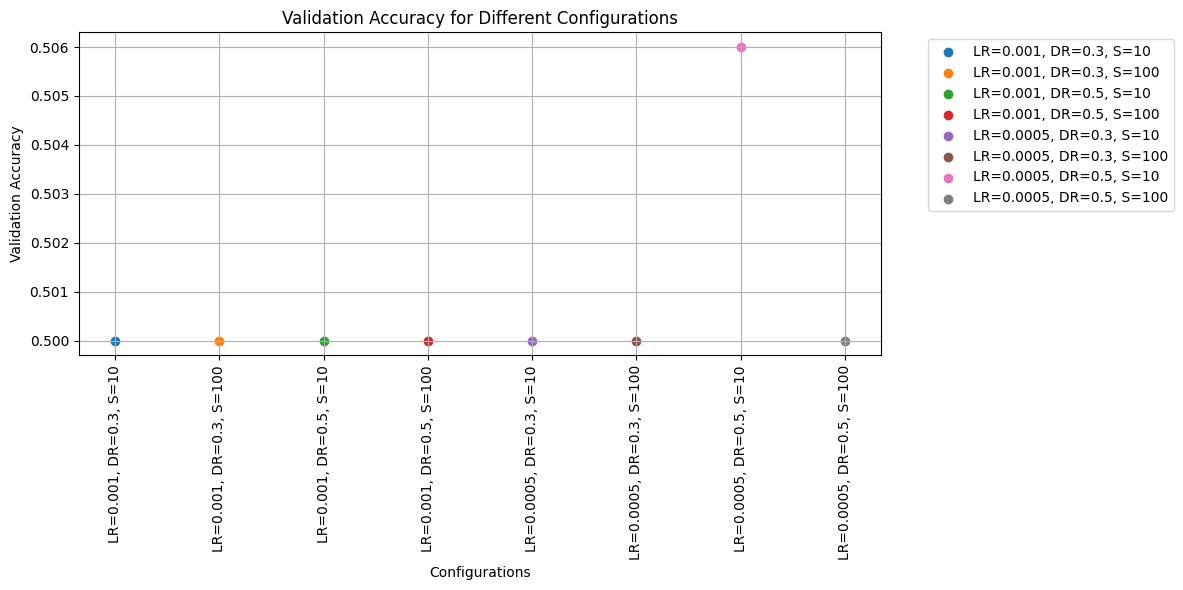

Best configuration: Learning Rate=0.0005, Dropout Rate=0.5, Inner Layer Size=10
Best Validation Accuracy: 0.5059999823570251


In [56]:
learning_rates = [0.001, 0.0005]
dropout_rates = [0.3, 0.5]
sizes = [10, 100]
scores = {}

for lr in learning_rates:
    for dr in dropout_rates:
        for s in sizes:
            
            model = tune_model(learning_rate=lr, dropout_rate=dr, size=s)
            
            # Train the model for a few epochs to compare performance
            history = model.fit(train_ds, epochs=1, validation_data=test_ds, verbose=1)
            
            # Store the validation accuracy for this configuration
            val_accuracy = max(history.history['val_accuracy'])
            scores[(lr, dr, s)] = val_accuracy

# Plotting results
plt.figure(figsize=(12, 6))
for (lr, dr, s), val_accuracy in scores.items():
    plt.scatter([f"LR={lr}, DR={dr}, S={s}"], [val_accuracy], label=f"LR={lr}, DR={dr}, S={s}")

plt.xticks(rotation=90)
plt.title("Validation Accuracy for Different Configurations")
plt.ylabel("Validation Accuracy")
plt.xlabel("Configurations")
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Find the best configuration
best_config = max(scores, key=scores.get)
best_val_accuracy = scores[best_config]

print(f"Best configuration: Learning Rate={best_config[0]}, Dropout Rate={best_config[1]}, Inner Layer Size={best_config[2]}")
print(f"Best Validation Accuracy: {best_val_accuracy}")

In [60]:
# Create the final model with the best hyperparameters
final_model = tune_model(
    learning_rate= 0.0005,
    dropout_rate= 0.5,
    size= 10
)

# %%
# Adding checkpoint and early stopping callbacks
checkpoint = ModelCheckpoint(
    filepath='best_cnn_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# %%
# Train the final model with full epochs
history = final_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=[checkpoint, early_stopping]
)

# Load the best model
best_model = load_model('best_cnn_model.h5')

# Save the final model for deployment
best_model.save('final_cnn_model.h5')
print("The final model has been saved for deployment.")


Epoch 1/5
2000/2000 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5104
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_cnn_model.h5
2000/2000 [==============================] - 151s 74ms/step - loss: 0.6933 - accuracy: 0.5104 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
2000/2000 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.5126
Epoch 2: val_accuracy did not improve from 0.50000
2000/2000 [==============================] - 139s 70ms/step - loss: 0.6925 - accuracy: 0.5126 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
2000/2000 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.5017
Epoch 3: val_accuracy improved from 0.50000 to 0.52350, saving model to best_cnn_model.h5
2000/2000 [==============================] - 137s 68ms/step - loss: 0.6927 - accuracy: 0.5017 - val_loss: 0.6924 - val_accuracy: 0.5235
Epoch 4/5
1999/2000 [============================>.] - ETA: 0s - loss: 0.

In [ ]:
#making some manual adjustment
final_model = tune_model(
    learning_rate= 0.00001,
    dropout_rate= 0.3,
    size= 100
)

# %%
# Adding checkpoint and early stopping callbacks
checkpoint = ModelCheckpoint(
    filepath='best_cnn_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# %%
# Train the final model with full epochs
history = final_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=[checkpoint, early_stopping]
)

# Load the best model
best_model = load_model('best_cnn_model.h5')

# Save the final model for deployment
best_model.save('final_cnn_model.h5')
print("The final model has been saved for deployment.")


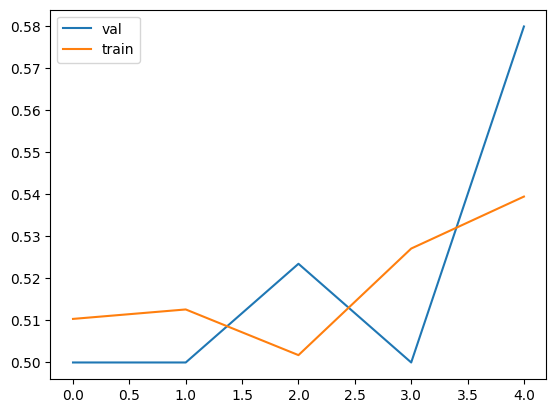

In [61]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')
 
plt.legend()

In [62]:
model.evaluate(test_ds)

500/500 [==============================] - 9s 18ms/step - loss: 0.6931 - accuracy: 0.5000


[0.6931460499763489, 0.5]

In [63]:
import numpy as np
 
path = 'C:/Users/SOOQ ELASER/Desktop/cat_dog_dataset/training_set/dogs/dog.43.jpg'
 
img = load_img(path, target_size=(150,150))
 
x = np.array(img)
X = np.array([x])
X.shape

pred = model.predict(X)

1/1 [==============================] - 0s 115ms/step


In [64]:
pred

array([[0.49997535]], dtype=float32)